In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import time 
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),            
    transforms.RandomHorizontalFlip(),        
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),            
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

batch_size = 16

data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.classes)

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)

In [18]:
resnet50 = models.resnet50(weights = 'DEFAULT')
resnet50 = resnet50.to(device)

In [19]:
for param in resnet50.parameters():
    param.requires_grads = False

In [20]:
fc_inputs = resnet50.fc.in_features  
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256), 
    nn.ReLU(),  
    nn.Dropout(0.4),  
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1)  
)

In [21]:
loss_func = nn.NLLLoss()  
learning_rate = 0.01  
optimizer = optim.SGD(
    params=resnet50.parameters(),  
    lr=learning_rate,  
    momentum=0.9  
)

In [22]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
    
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            train_acc += acc.item() * inputs.size(0)
        
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
    
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            
            torch.save(model, 'best_model.pt')
        
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history, best_epoch

In [23]:
print(summary(resnet50, input_size=(batch_size, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 7]                   --
├─Conv2d: 1-1                            [16, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 128, 128]        128
├─ReLU: 1-3                              [16, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [16, 64, 64, 64]          --
├─Sequential: 1-5                        [16, 256, 64, 64]         --
│    └─Bottleneck: 2-1                   [16, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [16, 64, 64, 64]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [16, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [16, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [16, 64, 64, 64]          --
│ 

In [24]:
num_epochs = 15
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

Epoch: 1/15
Epoch : 000, Training: Loss - 1.3527, Accuracy - 49.4007%, 
		Validation : Loss - 1.2214, Accuracy - 58.8521%, Time: 59.0387s
Epoch: 2/15
Epoch : 001, Training: Loss - 0.6279, Accuracy - 78.1989%, 
		Validation : Loss - 0.6399, Accuracy - 78.4047%, Time: 57.9250s
Epoch: 3/15
Epoch : 002, Training: Loss - 0.3667, Accuracy - 88.0466%, 
		Validation : Loss - 0.2078, Accuracy - 92.8988%, Time: 57.7090s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.2181, Accuracy - 93.0029%, 
		Validation : Loss - 0.1020, Accuracy - 96.8872%, Time: 57.9020s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.1545, Accuracy - 95.0113%, 
		Validation : Loss - 0.0766, Accuracy - 98.2490%, Time: 57.8799s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.1223, Accuracy - 95.9832%, 
		Validation : Loss - 0.0571, Accuracy - 97.7626%, Time: 57.8332s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.0819, Accuracy - 97.6676%, 
		Validation : Loss - 0.0374, Accuracy - 98.6381%, Time: 57.9543s
Epoch: 8/15
Epoch : 007, Training:

In [25]:
dataset = 'teeth'
torch.save(history, dataset+'_history.pt')

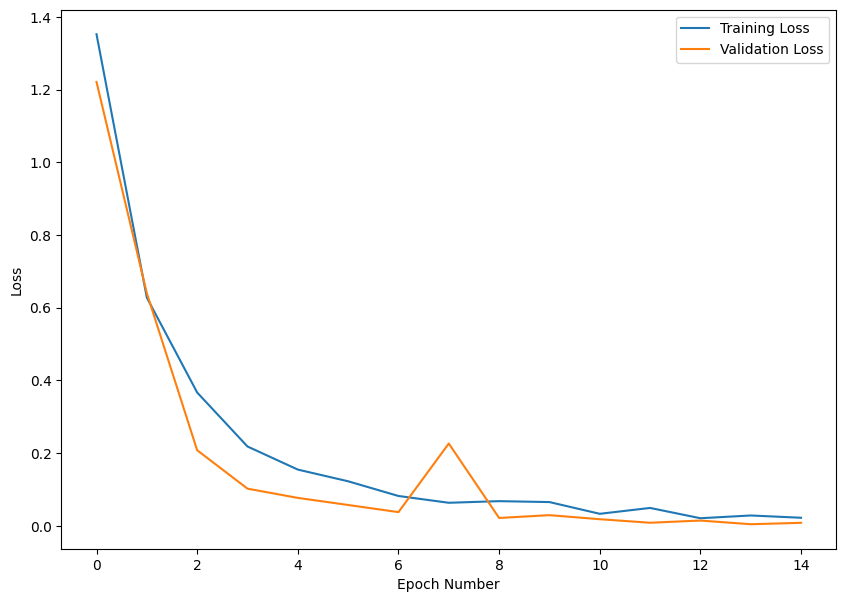

In [26]:
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

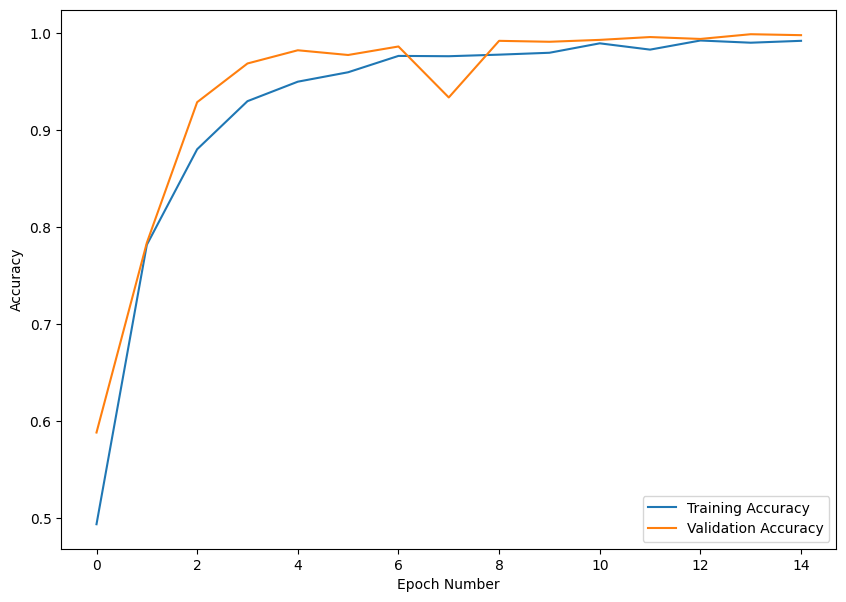

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

In [31]:
def computeTestSetAccuracy(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    
    with torch.no_grad():
        
        model.eval()

        
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            
            outputs = model(inputs)

            
            loss = loss_criterion(outputs, labels)

            
            test_loss += loss.item() * inputs.size(0)

            
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            
            test_acc += acc.item() * inputs.size(0)

            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))

In [32]:
model = torch.load("best_model.pt", weights_only=False)
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 001, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 002, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 003, Test: Loss: 0.0001, Accuracy: 1.0000
Test Batch number: 004, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 005, Test: Loss: 0.0003, Accuracy: 1.0000
Test Batch number: 006, Test: Loss: 0.0002, Accuracy: 1.0000
Test Batch number: 007, Test: Loss: 0.2245, Accuracy: 0.9375
Test Batch number: 008, Test: Loss: 0.0001, Accuracy: 1.0000
Test Batch number: 009, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 010, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 011, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 012, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 013, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 014, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 015, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 016, 